In [1]:
import torch
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import DebertaV2Tokenizer, DebertaV2ForSequenceClassification
from torch.optim import AdamW
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, RandomSampler, TensorDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, TensorDataset, RandomSampler
import matplotlib.pyplot as pltnfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import pickle
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# Configurazioni
TRAIN_PATH = "/content/drive/MyDrive/the_tokenizers_shared_folder/dataset/augmented_train_dataset.csv"
TEST_PATH = "/content/drive/MyDrive/the_tokenizers_shared_folder/dataset/augmented_dev_dataset.csv"
TEST_UNLABELED_PATH = "/content/drive/MyDrive/the_tokenizers_shared_folder/dataset/augmented_test_dataset.csv"
TEXT_COLUMN = "text"
LABEL_COLUMN = "label"
LEARNING_RATE = 5e-06
NUM_LABELS = 3
BATCH_SIZE = 8
EPOCHS = 2
FREEZE_LAYERS = 3
SAVE_DIR = "/content/drive/MyDrive/the_tokenizers_shared_folder/trained_model/model_roBERTa_full"
OUTPUT_CSV_PATH = "/content/drive/MyDrive/the_tokenizers_shared_folder/The_Tokenizers_output_LLM.csv"

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# TRAIN
tokenizer = RobertaTokenizer.from_pretrained("roberta-large")

# LOAD and PREPROCESSING train dataset
train_df = pd.read_csv(TRAIN_PATH)
train_df[TEXT_COLUMN] = train_df[TEXT_COLUMN].astype(str).fillna("")
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df[LABEL_COLUMN])
train_texts = train_df[TEXT_COLUMN].tolist()

train_encodings = tokenizer(train_texts, padding=True, truncation=True, return_tensors="pt")
train_dataset = TensorDataset(
    train_encodings["input_ids"],
    train_encodings["attention_mask"],
    torch.tensor(train_labels)
)

# Model
model = RobertaForSequenceClassification.from_pretrained("roberta-large", num_labels=NUM_LABELS)

# Freezing of first N layer
for name, param in model.roberta.named_parameters():
    if name.startswith("encoder.layer"):
        layer_num = int(name.split('.')[2])
        if layer_num < FREEZE_LAYERS:
            param.requires_grad = False

model.to(device)

# Ottimizzatore
# Only include trainable parameters in the optimizer.
# The lambda function filters out parameters where requires_grad=False (e.g., frozen layers).
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

# DataLoader
train_loader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset, generator=torch.Generator().manual_seed(SEED)),
    batch_size=BATCH_SIZE
)

# Training
model.train()
for epoch in range(EPOCHS):
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for batch in progress_bar:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} - Average Loss: {avg_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/2: 100%|██████████| 782/782 [29:41<00:00,  2.28s/it, loss=0.317]


Epoch 1 - Average Loss: 0.5749


Epoch 2/2: 100%|██████████| 782/782 [29:41<00:00,  2.28s/it, loss=0.374]

Epoch 2 - Average Loss: 0.3828


In [ ]:
# SAVE MODEL
model.save_pretrained(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)
with open(f"{SAVE_DIR}/label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

Predictions saved to predicted_dataset_output.csv

Evaluation Metrics
Accuracy : 0.7967
Precision: 0.8016
Recall   : 0.7967
F1-score : 0.7981

Classification Report
                         precision    recall  f1-score   support

      cultural agnostic       0.93      0.90      0.91       117
     cultural exclusive       0.67      0.76      0.72        76
cultural representative       0.75      0.71      0.73       107

               accuracy                           0.80       300
              macro avg       0.79      0.79      0.79       300
           weighted avg       0.80      0.80      0.80       300



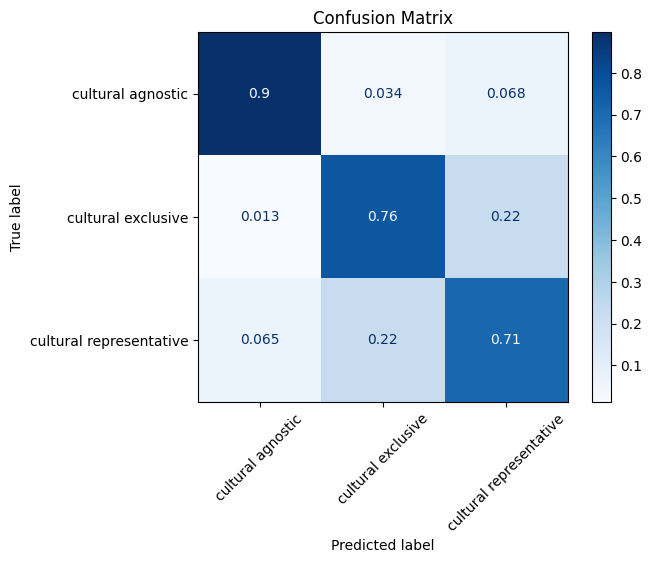

In [ ]:
# TEST OF TRAINED MODEL -> dev_set

# Inference
# Load trained model and tokenizer
tokenizer = RobertaTokenizer.from_pretrained(SAVE_DIR)
model = RobertaForSequenceClassification.from_pretrained(SAVE_DIR)
model.to(device)
model.eval()

# Load label encoder
with open(f"{SAVE_DIR}/label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

# Test set
test_df = pd.read_csv(TEST_PATH)
test_df[TEXT_COLUMN] = test_df[TEXT_COLUMN].astype(str).fillna("")
test_labels = label_encoder.transform(test_df[LABEL_COLUMN])
test_texts = test_df[TEXT_COLUMN].tolist()

test_encodings = tokenizer(test_texts, padding=True, truncation=True, return_tensors="pt")
test_dataset = TensorDataset(test_encodings["input_ids"], test_encodings["attention_mask"])
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


all_preds = []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask = [x.to(device) for x in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())

# Save Predictions
test_df["predicted_label"] = all_preds
test_df.to_csv("predicted_dataset_output.csv", index=False)
print("Predictions saved to predicted_dataset_output.csv")

# Metrics
accuracy = accuracy_score(test_labels, all_preds)
precision = precision_score(test_labels, all_preds, average="weighted")
recall = recall_score(test_labels, all_preds, average="weighted")
f1 = f1_score(test_labels, all_preds, average="weighted")

print("\nEvaluation Metrics")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

# Classification report
print("\nClassification Report")
print(classification_report(test_labels, all_preds, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(test_labels, all_preds, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

In [ ]:
# LOAD TRAINED MODEL
tokenizer = RobertaTokenizer.from_pretrained(SAVE_DIR)
model = RobertaForSequenceClassification.from_pretrained(SAVE_DIR)
model.to(device)
model.eval()

with open(f"{SAVE_DIR}/label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

# LOAD TEST UNLABELED DATASET
df = pd.read_csv(TEST_UNLABELED_PATH)
df[TEXT_COLUMN] = df[TEXT_COLUMN].astype(str).fillna("")
texts = df[TEXT_COLUMN].tolist()

encodings = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
dataset = TensorDataset(encodings["input_ids"], encodings["attention_mask"])
loader = DataLoader(dataset, batch_size=BATCH_SIZE)

print("Prediction labels")
all_preds = []
with torch.no_grad():
    for batch in tqdm(loader, desc="Predicting"):
        input_ids, attention_mask = [x.to(device) for x in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())

# DECODE LABELS
predicted_labels = label_encoder.inverse_transform(all_preds)
df["label"] = predicted_labels
df.to_csv(OUTPUT_CSV_PATH, index=False)
print(f"Predictions saved to: {OUTPUT_CSV_PATH}")

Prediction labels


Predicting: 100%|██████████| 38/38 [00:20<00:00,  1.82it/s]

Predictions saved to: /content/drive/MyDrive/MNLP/dataset/test_labeled_predicted.csv


In [ ]:
# LOAD DATASET
df = pd.read_csv(OUTPUT_CSV_PATH)

columns_to_keep = ["item", "name", "label"]
df_filtered = df[columns_to_keep]

filtered_output_path = "/content/drive/MyDrive/the_tokenizers_shared_folder/The_Tokenizers_output_LLM.csv"
df_filtered.to_csv(filtered_output_path, index=False)